<center>
    COMP4600/5500 - Reinforcement Learning

# Homework 4 - Monte Carlo

### Due: Monday, October 11th 11:59 pm
    
</center>

Student Name: Mohamed Martini

The purpose of this project is to study different properties of Monte Carlo methods.  

In [1]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from blackjack import BlackJack

In [2]:
def plot_V(V, title):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.set_title(title, size=18)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('State value function')

    # Make data.
    X = np.arange(1, 11)
    Y = np.arange(12, 22)
    X, Y = np.meshgrid(X, Y)

    Z0 = V[0]
    Z1 = V[1]

    # Plot the surface.
    ax.plot_wireframe(X, Y, Z0, color="blue", label="Non-usable Ace")#, label="Non-usable Ace")
    ax.plot_wireframe(X, Y, Z1, color="red", label="Usable Ace")

    # Customize the z axis.
    ax.set_zlim(-1, 5)

    ax.legend()

    plt.show()

def plot_Pi(Pi, titles): 
    import seaborn as sns
    titles = titles
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    for i in range(len(axes)):
        sns.heatmap(Pi[i], cbar=False, ax=axes[i], annot=True)
        axes[i].set_title(titles[i], size=18)
        axes[i].invert_yaxis()
        axes[i].set_xlabel("Dealer showing", size=16)
        axes[i].set_ylabel("Player sum", size=16)
        axes[i].set_xticklabels([f"{i}" for i in range(1, 11)])
        axes[i].set_yticklabels([f"{i}" for i in range(12, 22)])

    fig.text(0.9, 0.2, 'Hit', ha='center', size=50, color="red")
    fig.text(0.4, 0.2, 'Hit', ha='center', size=50, color="red")
    fig.text(0.9, 0.8, 'Stick', ha='center', size=50, color="red")
    fig.text(0.4, 0.8, 'Stick', ha='center', size=50, color="red")

    plt.tight_layout()
    plt.show()

## Problem
The objective of the popular casino card game of blackjack is to obtain cards that sum of whose numerical values is as great as possible without exceeding 21. All face cards count as 10, and an ace can count either as 1 or as 11. We consider the version in which each player competes independently against the dealer. The game begins with two cards dealt to both dealer and player. One of the dealer’s cards is face up and the other is face down. If the player has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the game is a draw. If the player does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). If he goes bust, he loses; if he sticks, then it becomes the dealer’s turn. The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome—win, lose, or draw—is determined by whose final sum is closer to 21. 

Playing blackjack is naturally formulated as an **episodic** finite MDP. Each game of blackjack is an episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero, and we do not discount ($\gamma=1$); therefore these terminal rewards are also the returns. The player’s actions are to hit or to stick. The states depend on the player’s cards and the dealer’s showing card. We assume that cards are dealt from an infinite deck (i.e., with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that he could count as 11 without going bust, then the ace is said to be usable. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: his current sum (12–21), the dealer’s one showing card (ace–10), and whether or not he holds a usable ace. This makes for a total of 200 states.




**Note:** for this homework you should use the implementation of the Blackjack game and you can import it into your notebook.

You do not need to submit the `blackjack.py` file. We recommend you do not make changes to the `blackjack.py` file, because we use our file while running and grading your submission.

## Part I

1. Write a python function for the player policy that sticks if the player’s sum is 19, 20, or 21, and hits otherwise. The input to this function should be states and the output should be the action. Then use this function to play Blackjack and print out 3 sample trajectories.
2. Implement the **First-visit Monte Carlo prediction** algorithm and consider the player policy you developed in the previous step. Estimate the state-value function for this policy using the first-visit Monte Carlo prediction algorithm by simulating 500,000 blackjack games using the policy and average the returns following each state. Plot the 3D graph of state-value (z-axis), dealer showing (x-axis), player sum (y-axis) for both usable ace and not usable ace states (i.e., you should have two plots). Your implementation should use the **incremental sample-average**.


In [3]:
GAMMA = 1
S_player = [i for i in range(12, 22)]  # player states
S_dealer = [i for i in range(1, 11)]  # dealer states
S_ace = [0, 1]
S = np.zeros((len(S_ace), len(S_player), len(S_dealer)))
NUM_STATES = np.product(S.shape)

PLAYER, DEALER, ACE = 0, 1, 2  # order of things in a state
HIT, STICK = 0, 1  # order of actions in A

bjack = BlackJack()


def _Pi_s(player, dealer, ace):
    """
    given a state, return an action
    """
    if player < 19:
        return HIT
    return STICK


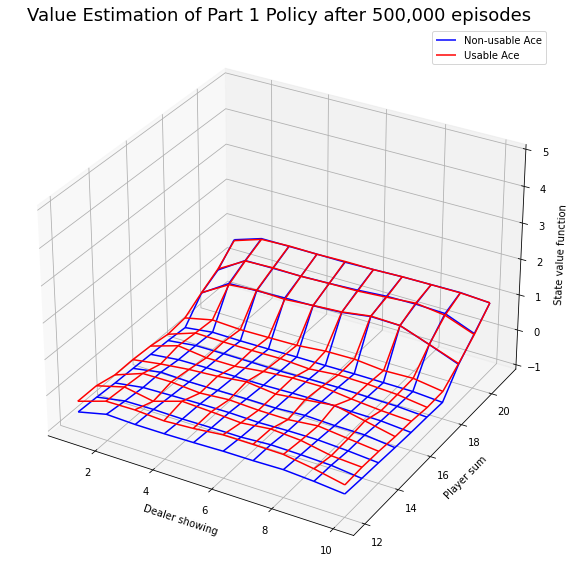

In [4]:
def get_states(episode):
    states = []
    for step in episode:
        states.append(step[0])
    return states

def first_visit_mc(k=500_000):
    """
    given a policy, calculate the values of all states
    """
    V_pi = np.zeros_like(S)
    states_visits = dict()
    
    for _ in range(k):
        S_0, r, episode = bjack.play(_Pi_s)
        num_steps = len(episode)
        states = get_states(episode)
        G = r
        for step in range(num_steps - 1, -1, -1):
            s = states[step]
            if s in states[:step]:
                continue
            try:
                states_visits[s] += 1
            except KeyError:
                states_visits[s] = 1
                
            ace, player, dealer = s
            
            v_old = V_pi[S_ace.index(ace), S_player.index(player), S_dealer.index(dealer)]

            v_new = v_old + (G - v_old) / states_visits[s]
            V_pi[S_ace.index(ace), S_player.index(player), S_dealer.index(dealer)] = v_new

    return V_pi

V1 = first_visit_mc(k=500_000)

title = "Value Estimation of Part 1 Policy after 500,000 episodes"
plot_V(V1, title)

## Part II
1. Use the previous policy (sticks if the player’s sum is 19, 20, or 21, and otherwise hits) as the initial policy and find (i) the action-value estimates and (ii) the optimal policy using Monte Carlo with Exploring Starts. To make the starting states with uniform probabilities, pick the dealer’s cards, the player’s sum, and whether or not the player has a usable ace, according to a uniform sampling process. 
2. Plot the 3D graph of state-value (z-axis), dealer showing (x-axis), player sum (y-axis) for both usable ace and not usable ace states (i.e., you should have two plots) for 500,000 simulated games. Also plot the optimal policy for both the usable ace and not usable ace states for all the player’s sum and dealer showing (i.e., you should have two plots).

In [5]:
def my_argmax(a):
    max_ = max(a)
    indx = [i for i in range(len(a)) if a[i] == max_]
    return np.random.choice(indx)

def first_visit_ex_starts_mc(k=500_000):
    """
    given a policy, calculate the values of all states
    """
    V_pi = np.zeros_like(S)
    Pi = np.zeros_like(S)
    Q = [np.copy(Pi), np.copy(Pi)]
    state_action_visits = dict()
    
    for _ in range(k):
        _, r, episode = bjack.play(_Pi_s, initial_action=np.random.choice([0, 1]))
        num_steps = len(episode)
        G = r
        for step in range(num_steps - 1, -1, -1):
            s_a = tuple(episode[step])
            if s_a in episode[:step]:
                continue
            try:
                state_action_visits[s_a] += 1
            except KeyError:
                state_action_visits[s_a] = 1
                
            (ace, player, dealer), a = s_a
            index = [S_ace.index(ace), S_player.index(player), S_dealer.index(dealer)]
            
            old = Q[a][index[0], index[1], index[2]]
            new = old + (G - old) / state_action_visits[s_a]

            Q[a][index[0], index[1], index[2]] = new
            
            Q_a = [Q[0][index[0], index[1], index[2]], Q[1][index[0], index[1], index[2]]]

            V_pi[index[0], index[1], index[2]] = max(Q_a)
            Pi[index[0], index[1], index[2]] = my_argmax(Q_a)

    return V_pi, Pi

V2, Pi2 = first_visit_ex_starts_mc(k=500_000)


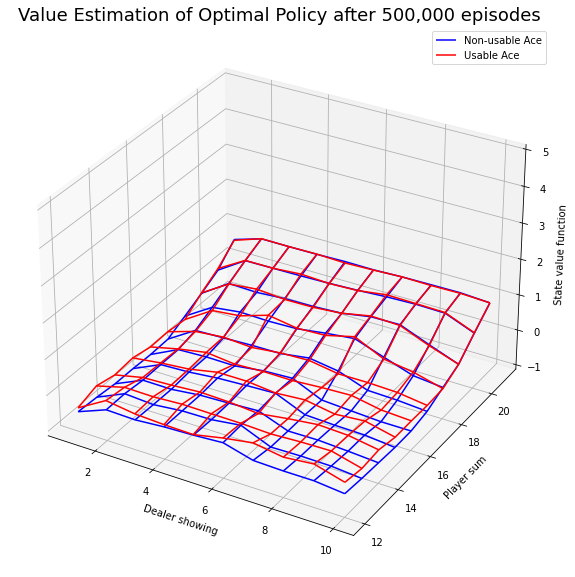

In [6]:
title = "Value Estimation of Optimal Policy after 500,000 episodes"
plot_V(V2, title)


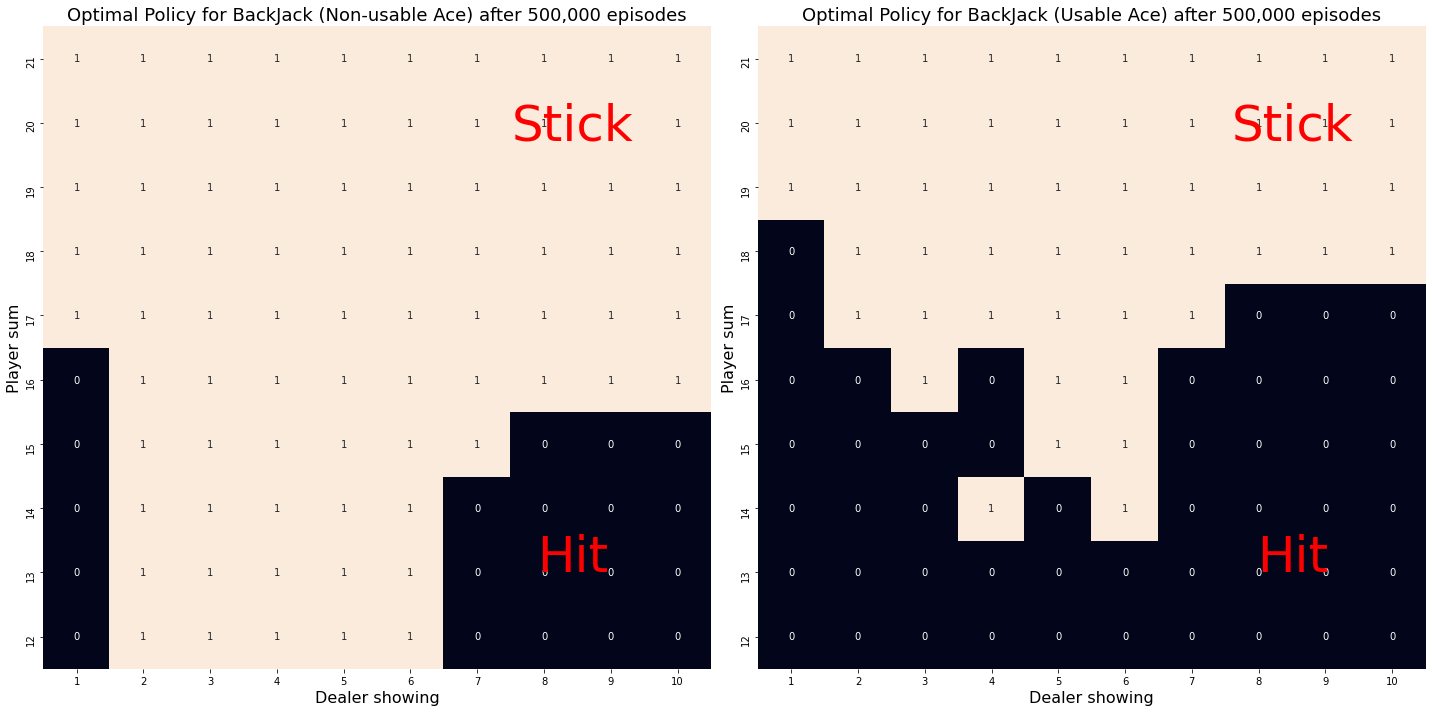

In [7]:
titles = ["Optimal Policy for BackJack (Non-usable Ace) after 500,000 episodes",
         "Optimal Policy for BackJack (Usable Ace) after 500,000 episodes"]
plot_Pi(Pi2, titles)

## Part III (*)
1. Extend your algorithm to the **off-policy Monte Carlo control with weighted importance sampling** and estimate action-values and the target policy. You need to consider an arbitrary soft behavior policy. Plot the 3D graph of state-value (z-axis), dealer showing (x-axis), player sum (y-axis) for both usable ace and not usable ace states (i.e. you should have two plots) for 500,000 simulated games. Also plot the optimal policy for both the usable ace and not usable ace states for all the player’s sum and dealer showing (i.e. you should have two plots).
2. Answer the following questions:



In [8]:
NUM_ACTIONS = 2
EPS = 0.3

def _Pi_s_soft(player, dealer, ace, eps=EPS):
    """
    given a state, return a stochastic action
    """
    if player == 21:
        return STICK
    if player < 16:
        p = (1 - eps, eps)
    else:
        p = (eps, 1 - eps)
    return np.random.choice((HIT, STICK), p=p)

def _Pi_s_a_soft(action, player, dealer, ace, eps=EPS):
    """
    given a state and action, return action probability
    """
    if player == 21:
        if action == 0:
            return 0
        else:
            return 1
    if player < 16:
        if action == 0:
            return 1 - eps
        else: 
            return eps
    else:
        if action == 0:
            return eps
        else: 
            return 1 - eps


def off_pi_mc(Pi, k=500_000):
    """
    receive the policy from part 1 and improve it by playing _Pi_s_soft
    """
    Q = np.zeros((NUM_ACTIONS, len(S_ace), len(S_player), len(S_dealer)))
    C = np.zeros_like(Q)
    
    for _ in range(k):
        _, r, episode = bjack.play(policy_player_=_Pi_s_soft)
        G = r
        W = 1
        for t in range(len(episode) - 1, -1, -1):
            state = episode[t]
            (ace, player, dealer), action = state
            s_ace, s_player, s_dealer = S_ace.index(ace), \
                                        S_player.index(player), \
                                        S_dealer.index(dealer)
            C[action, s_ace, s_player, s_dealer] += W
            C_val = C[action, s_ace, s_player, s_dealer]
            Q_val = Q[action, s_ace, s_player, s_dealer]
            Q[action, s_ace, s_player, s_dealer] = Q_val + (W / C_val) * (G - Q_val)
            Pi[s_ace, s_player, s_dealer] = my_argmax(Q[:, s_ace, s_player, s_dealer])
            if Pi[s_ace, s_player, s_dealer] != action:
                break
            W *= (1 / _Pi_s_a_soft(action, player, dealer, ace))

    V = np.max(Q, axis=0)
    return V, Pi, Q

target_policy = np.zeros_like(S)
target_policy[:, 7:, :] = 1

V3, Pi3, Q3 = off_pi_mc(Pi=target_policy)

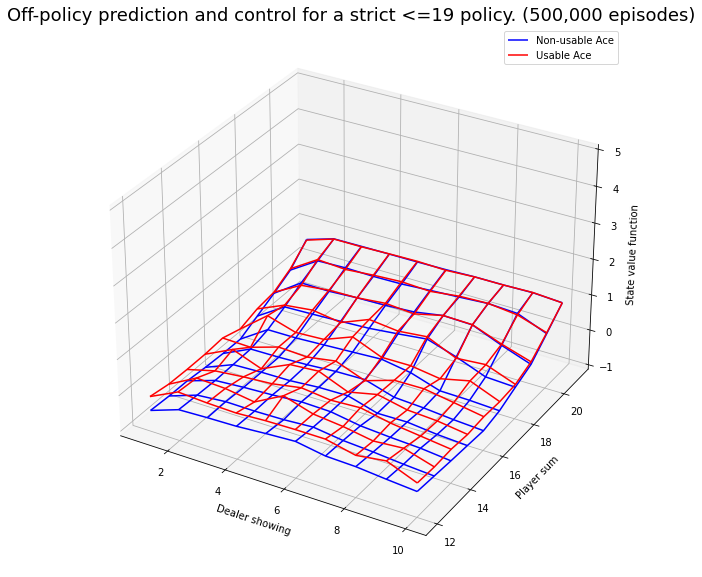

In [9]:
title = "Off-policy prediction and control for a strict <=19 policy. (500,000 episodes)"
plot_V(V3, title)


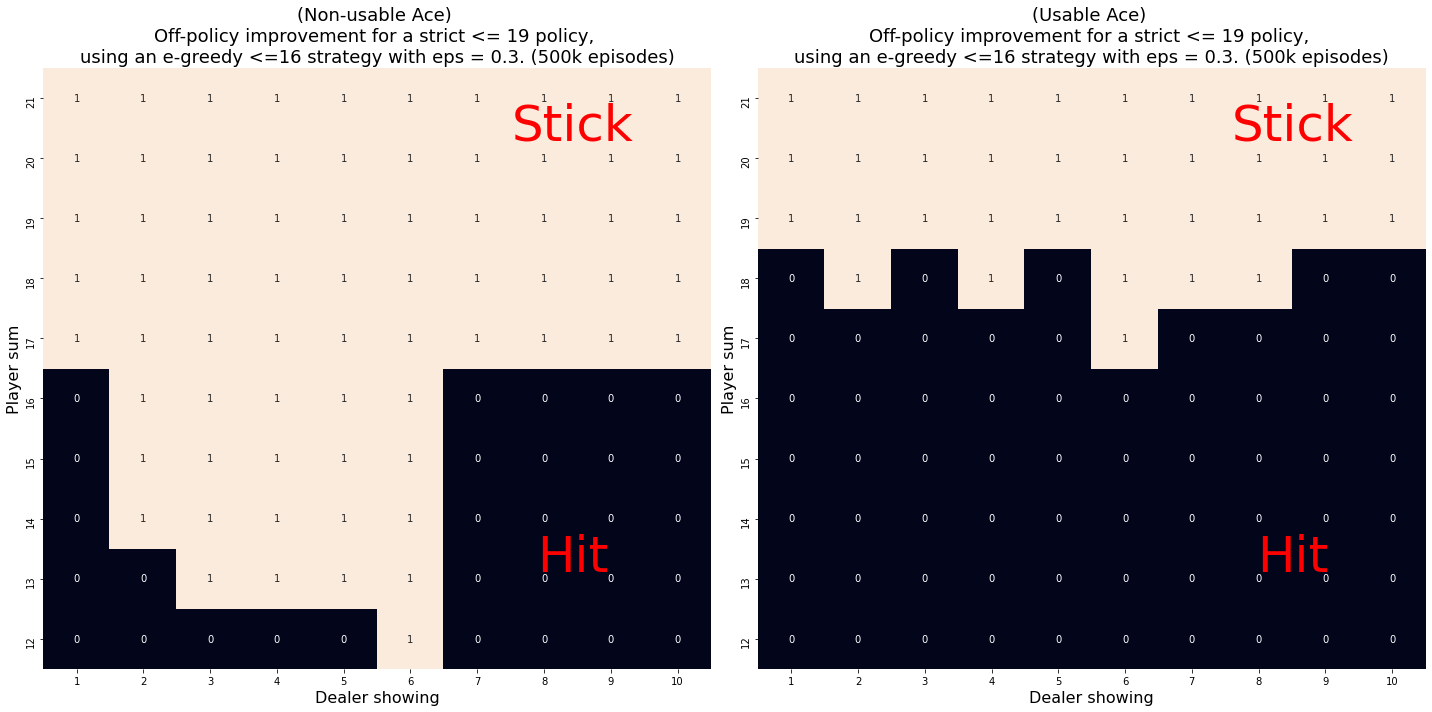

In [10]:
titles = [f"(Non-usable Ace) \nOff-policy improvement for a strict <= 19 policy, \nusing an e-greedy <=16 strategy with eps = {EPS}. (500k episodes)",
          f"(Usable Ace) \nOff-policy improvement for a strict <= 19 policy, \nusing an e-greedy <=16 strategy with eps = {EPS}. (500k episodes)"]
plot_Pi(Pi3, titles)

a.	What behavior policy did you select? Why does it make sense?
> Answer $\newline$ 
bahevior policy: $\newline$
if sum = 21 : hit (100%) $\newline$
if sum < 16 : hit (70%) $\newline$
if sum >= 16: hit (30%) $\newline$
target policy: $\newline$
if sum < 19 : hit (100%) $\newline$
else:         hit (0%) $\newline$
It makes sense to use an exploratory policy to modify the target strict policy.

b.	How does the obtained target policy in this part compare to the target policies in parts I and II? Is it different? Why? 
> Answer $\newline$
The obtained policy is more encouraged to "hit" than the previous policies. The reason for this is the previous algorithms started from a very strick policy with only exploring starts. The limited exploration limits the improvement of the algorithm. As exploration increased, the algorithm found increased value in "hitting" at vertain states. 